In [19]:
# General libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

In [20]:
# SAM libraries
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx


In [21]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [22]:
# Download SAM checkpoint
import os

# Check if the file already exists
if not os.path.exists("sam_vit_h_4b8939.pth"):
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
else:
    print("File already exists, skipping download.")


File already exists, skipping download.


In [23]:
### import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir, 
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems 


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Source image size:(3923, 5811)
Target image size:(512, 512)


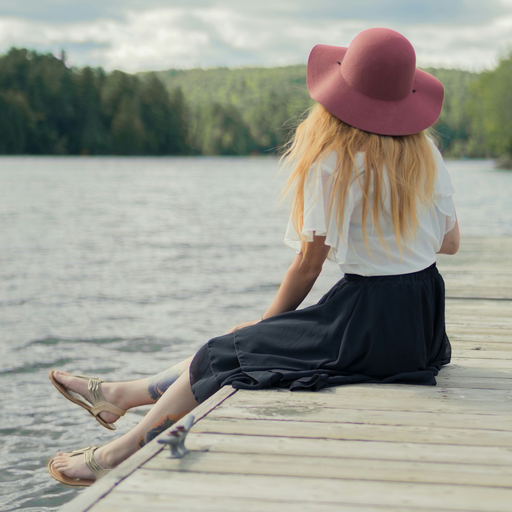

In [24]:
# image

target_width, target_height = 512,512
source_image = Image.open('mix909-AsJirOOLN_s-unsplash.jpg')

width, height = source_image.size
print(f"Source image size:{source_image.size}")

# make square
source_image = source_image.crop((0,height-width, width, height))

# resize to target dimensions (to use less memory)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f"Target image size:{source_image.size}")

# convert into an array (to use it later with segmentation model)
segmentation_image = asarray(source_image)

display(source_image)


In [25]:
# Initialize SAM

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device="cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99, # filter threshold in [0,1], using model's predicted mask quality
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, # needs open-cv to run post-processing
)

/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

In [28]:
# Run SAM
masks = mask_generator.generate(segmentation_image)

# Print number of generated mask and keys attached to each of tehm
print(f"Number of masks generated:{len(masks)}")
print(masks[0].keys())


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 23.63 GiB of which 276.50 MiB is free. Including non-PyTorch memory, this process has 13.68 GiB memory in use. Process 22647 has 9.05 GiB memory in use. Of the allocated memory 11.96 GiB is allocated by PyTorch, and 1.26 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
# helper function : visualize masks and identifying number

def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')



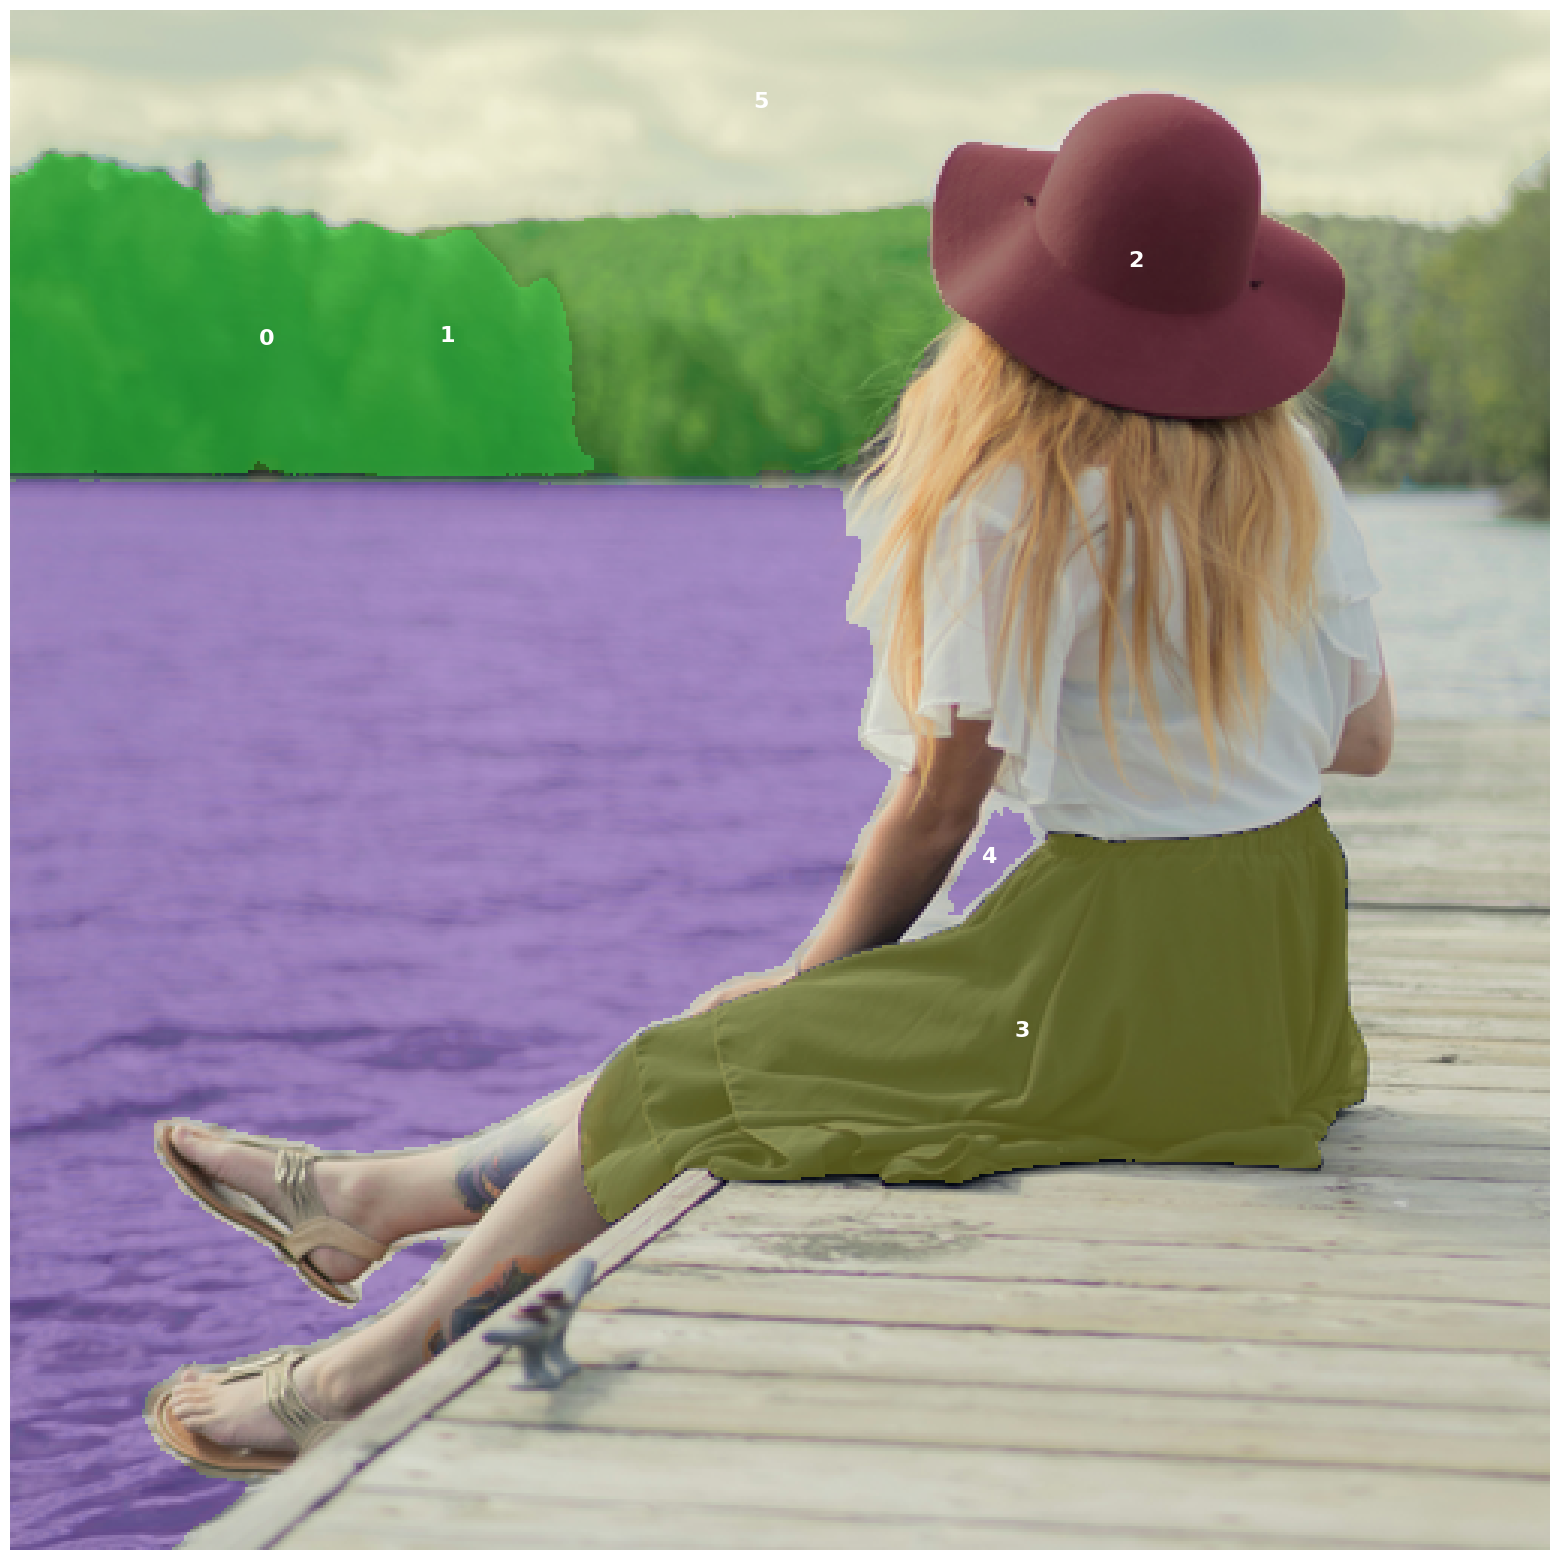

In [10]:
# Display masks with number
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks[:-5])
plt.axis('off')
plt.show()

In [11]:
# Explore one of the keys of the mask
for i, values in enumerate(masks):
    print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")


0: Area: 16200 | IoU: 1.0108189582824707
1: Area: 26581 | IoU: 1.0006424188613892
2: Area: 10621 | IoU: 1.0191541910171509
3: Area: 21817 | IoU: 1.01728093624115
4: Area: 66848 | IoU: 1.0150485038757324
5: Area: 29789 | IoU: 1.0128532648086548
6: Area: 4159 | IoU: 1.0035456418991089
7: Area: 506 | IoU: 0.9962245225906372
8: Area: 11149 | IoU: 0.9933706521987915
9: Area: 54744 | IoU: 1.0455783605575562
10: Area: 63265 | IoU: 1.0091361999511719


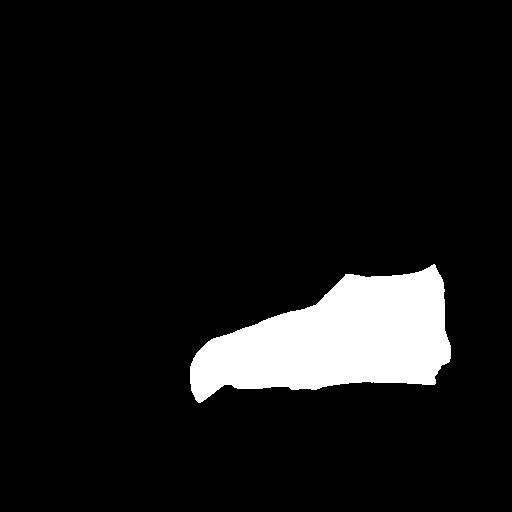

In [12]:
# Decide which mask to inpaint with
mask_index = 3

segmentation_mask = masks[mask_index]['segmentation']
stable_diffusion_mask = PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

(512, 512) (512, 512)


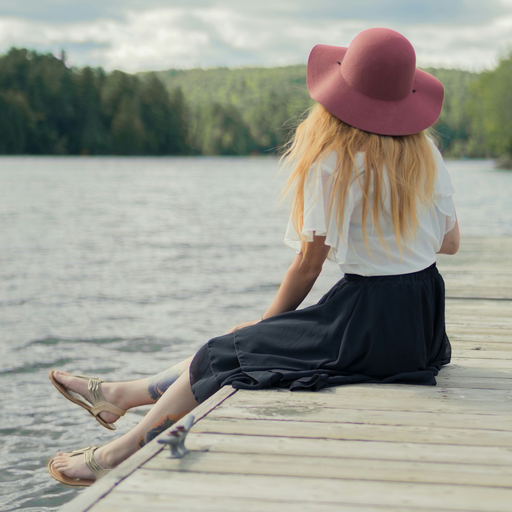

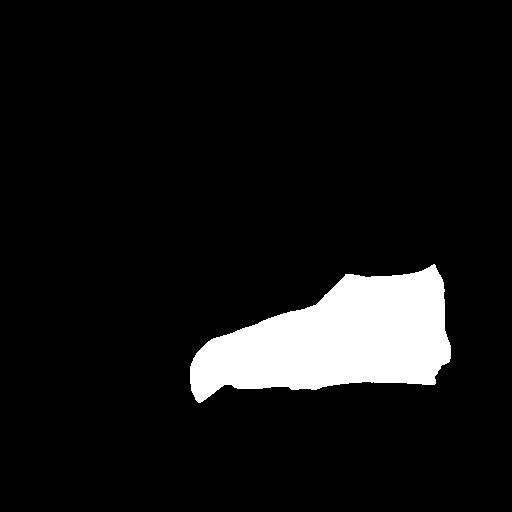

In [13]:
print(source_image.size, stable_diffusion_mask.size)
display(source_image)
display(stable_diffusion_mask)

In [14]:
print(pipe.config)

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')), ('text_encoder', ('transformers', 'CLIPTextModel')), ('tokenizer', ('transformers', 'CLIPTokenizer')), ('unet', ('diffusers', 'UNet2DConditionModel')), ('scheduler', ('diffusers', 'EulerDiscreteScheduler')), ('safety_checker', (None, None)), ('feature_extractor', ('transformers', 'CLIPImageProcessor')), ('image_encoder', (None, None)), ('requires_safety_checker', False), ('_name_or_path', 'stabilityai/stable-diffusion-2-inpainting')])


In [27]:
# setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = ["a skirt full of text",  "red flowers", "blue flowers", "a zebra skirt"]
generator = torch.Generator(device="cuda").manual_seed(155)

image = pipe(inpainting_prompts[0], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]


# # Run Stable Diffusion pipeline in inpainting mode
# encoded_images = []
# for i in range(num_images_per_prompt):
#     image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
#     encoded_images.append(image)


  0%|          | 0/60 [00:00<?, ?it/s]

In [17]:
test_image = pipe(prompt="a beautiful landscape").images[0]
test_image.show()
print("Text-only pipeline test successful.")
display(test_image)

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (9) must match the size of tensor b (4) at non-singleton dimension 1